# Generating Synthetic Data preserving One-and Two-Way Marginals via Covariance

In [87]:
import numpy as np
import pandas as pd
import pygwalker as pyg
import seaborn as sb
from scipy.linalg import cholesky
import matplotlib.pyplot as plt
from pylab import *
import pyAgrum as gum

import pyAgrum.lib.notebook as gnb
from sklearn.preprocessing import normalize

## Initi
def generateSyntheticRow(mean, L, dim=2):
    y = [[np.random.normal(0)]
        ,[np.random.normal(0)]
        ,[np.random.normal(0)]
        ,[np.random.normal(0)]
        ,[np.random.normal(0)]
        ,[np.random.normal(0)]
        ,[np.random.normal(0)]
        ,[np.random.normal(0)]
         ]
    row = np.matmul(L, y) + mean
    return row.sum(axis=1) \
        .reshape(-1,1) # transposing it

def generateSimpleNetwork(sampleSize, px=[0.1,0.9], py=[[.2,.8],[.2,.8]]):
    bn=gum.fastBN("x->y")
    bn.cpt("x").fillWith(px)
    bn.cpt("y")[:]=py
    ie=gum.LazyPropagation(bn)
    ie.makeInference()
    ie.posterior("x")
    bn.cpt("y")
    g=gum.BNDatabaseGenerator(bn)
    g.setRandomVarOrder()
    g.drawSamples(sampleSize,{})
    df3 = g.to_pandas()
    print(df3.astype("float32").mean().to_numpy())
    print(df3.corr(numeric_only=False))
    return bn, df3

In [ ]:
# Independent
#n_samples= 1000

#independent_features = np.random.rand(2, n_samples)

## Dependent (use noise create 4 dependent on the first)
#base = np.random.rand(2, n_samples)
#noise = np.random.normal(0, 0.1, size=(2, n_samples))
#dependent_features = np.hstack((base, base + noise))
#dataset = np.hstack((independent_features, dependent_features))

#print(dataset)
#np.cov(dataset)

In [24]:
## Generate Data with correlations from a Bayesan Network
## Not necessarily positive semidefinite

bn, df3 = generateSimpleNetwork(100000)
gnb.flow.row(bn,gnb.getInference(bn, evs ={'x':0}))
gnb.flow.row(bn,gnb.getInference(bn, evs ={'x':1}))
gnb.flow.row(bn,gnb.getInference(bn, evs ={}))



[1.      0.30176]
    x    y
x NaN  NaN
y NaN  1.0


[0.9013 0.7955]
          x         y
x  1.000000  0.011769
y  0.011769  1.000000


INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


real mean x: 0.8026
real mean y: 0.591


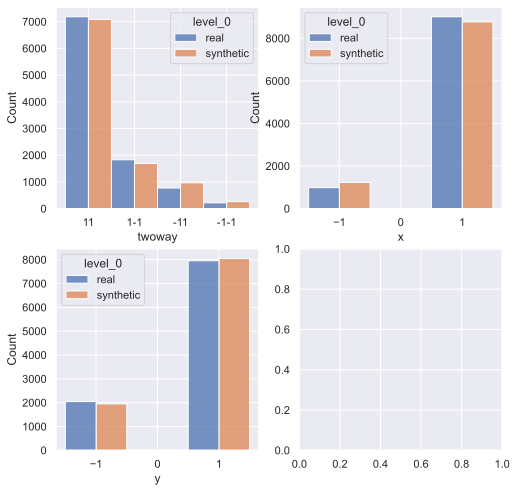

In [80]:
## First tries with uncorrelated data
def mergeDataFrames(realData, synthetic_data):
    df1 = realData \
        .applymap(lambda x: (-1 if int(x) <= 0 else 1))
    df2 = pd.DataFrame(synthetic_data.T, columns=["x","y"]) \
        .applymap(lambda x: (-1 if int(x) <= 0 else 1))
    df1['twoway'] = df1['x'].astype(str) + df1['y'].astype(str)
    df2['twoway'] = df2['x'].astype(str) + df2['y'].astype(str)
    df = pd.concat([df1,df2])
    return df, df1, df2

# Parameterizations
DATA_SIZE, SAMPLE_SIZE, dims = (10000, 10000, 2)
shape = (dims, DATA_SIZE)
bn, realData = generateSimpleNetwork(SAMPLE_SIZE)
mean = realData.astype("float32").mean().to_numpy()
# Computing Sample Strategy
cov = realData.cov(numeric_only=False) # dataframe
L = cholesky(cov)
synthetic_data = np.array(generateSyntheticRow(mean, L))
for i in range(SAMPLE_SIZE-1):
    synthetic_data = np.append(synthetic_data,generateSyntheticRow(mean, L), axis=1)

(df, df1, df2) = mergeDataFrames(realData, synthetic_data)

## Visualization / Graphing
viewdata = pd.concat([df1, df2], axis=0, keys=['real','synthetic']).reset_index(level=[0])
sb.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
sb.histplot(data = viewdata, x="twoway", bins = 4, ax=axs[0][0], discrete=True,  hue='level_0', multiple="dodge")
sb.histplot(data = viewdata, x="x", bins = 4, ax=axs[0][1], discrete=True,  hue='level_0', multiple="dodge", label="oneway")
sb.histplot(data = viewdata, x="y", bins = 4, ax=axs[1][0], discrete=True,  hue='level_0', multiple="dodge")

dt = {'names':['x', 'y'], 'formats':[float, float]}
synthetic_data_fresh = np.zeros(SAMPLE_SIZE, dtype=dt)
synthetic_data_fresh['x']= synthetic_data[0]
synthetic_data_fresh['y']= synthetic_data[1]

#print(synthetic_data_fresh.dtype.names)
#sb.relplot(data= synthetic_data_fresh,x='x')

print("real mean x: " + str(df1['x'].mean()))
print("real mean y: " + str(df1['y'].mean()))

## Problems: If there was no sample drawn from the covariance matrix, then there will also be no sample in our resulting matrix

# Simulating Correlated Gaussian


[0.48142593 0.87648678]
[0.77358213 0.63369606]
[0.79671628 0.60435351]
[0.83830976 0.54519423]
[0.8450859  0.53463055]
[0.71778505 0.69626476]
[0.57191373 0.82031377]
[0.6218882  0.78310604]
[0.55377717 0.83266491]
[0.68964612 0.72414655]
[0.53060378 0.84761998]
[0.30228056 0.953219  ]
[0.42899921 0.90330486]
[0.88478851 0.4659928 ]
[0.91829629 0.39589383]
[0.71588609 0.69821709]
[0.65454519 0.75602288]
[0.63693016 0.77092151]
[0.91880908 0.39470225]
[0.89980601 0.43629021]
[0.1172699  0.99310008]
[0.87802128 0.47862159]
[0.06878066 0.99763181]
[0.75218685 0.65894988]
[0.78815161 0.61548115]
[0.70020201 0.71394478]
[0.79794731 0.60272721]
[-0.14973533  0.98872612]
[0.74571828 0.66626139]
[0.66391913 0.74780438]
[0.81626012 0.57768454]
[0.56502722 0.82507226]
[0.90456065 0.42634497]
[0.92416011 0.38200536]
[0.30215565 0.9532586 ]
[0.68340038 0.73004378]
[0.90857297 0.41772618]
[0.72512317 0.68861919]
[0.83852624 0.54486121]
[0.47352753 0.88077902]
[0.24913816 0.96846795]
[0.82050202 0.

/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_35119/3536221212.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x = np.random.multivariate_normal([1,1], [[0.001,0],[0.5,0.0]])
/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_35119/3536221212.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x = np.random.multivariate_normal([1,1], [[0.001,0],[0.5,0.0]])
/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_35119/3536221212.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x = np.random.multivariate_normal([1,1], [[0.001,0],[0.5,0.0]])
/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_35119/3536221212.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x = np.random.multivariate_normal([1,1], [[0.001,0],[0.5,0.0]])
/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_35119/3536221212.py:7: RuntimeWarning: covariance is not symmetric positive-semid

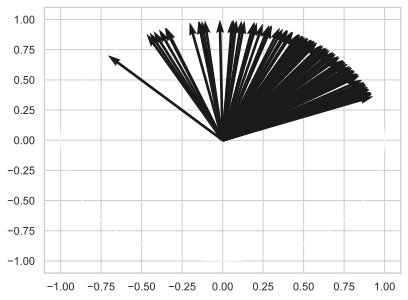

In [160]:
fig, ax = plt.subplots()
circle1 = plt.Circle((0, 0), radius=1, fill=False)
V = np.array([[1,1]])

for i in range(120):
    # x = generateSyntheticRow(mean, L)
    x = np.random.multivariate_normal([1,1], [[0.001,0],[0.5,0.0]])
    #x = np.ones(shape=(2,1))
    #x = np.array([1,1])
    x = x.reshape(-1,1)
    norm2 = normalize(x, axis=0).ravel()
    print(norm2)
    X = [0]
    Y = [0]
    U = [norm2[0]]
    V = [norm2[1]]
    plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)

origin = np.array([[0, 0, 0],[0, 0, 0]])
#plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'])
ax.add_patch(circle1)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # For reproducibility

# Parameters of the Gaussian distribution
mean = np.array([0, 0])
cov = np.array([[1, 0], [0, 1]])

# Generate random samples
samples = np.random.multivariate_normal(mean, cov, 1000)

# Plot the samples
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5)
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples from a 2D Gaussian Distribution')
plt.show()


In [144]:
 from numpy import genfromtxt


,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Smoking_History
Exercise,0.174341,-0.010967,-0.000493,-0.006713,-0.014162,-0.020000,-0.024453,-0.019127
Heart_Disease,-0.010967,0.074314,0.007333,0.007445,0.003549,0.016604,0.019687,0.014429
Skin_Cancer,-0.000493,0.007333,0.087683,0.013202,-0.001543,0.003843,0.018920,0.004773
Other_Cancer,-0.006713,0.007445,0.013202,0.087380,0.001881,0.007029,0.017942,0.007755
Depression,-0.014162,0.003549,-0.001543,0.001881,0.160253,0.005993,0.022840,0.019710
Diabetes,-0.020000,0.016604,0.003843,0.007029,0.005993,0.113148,0.022108,0.009502
Arthritis,-0.024453,0.019687,0.018920,0.017942,0.022840,0.022108,0.220157,0.028382
Smoking_History,-0.019127,0.014429,0.004773,0.007755,0.019710,0.009502,0.028382,0.241085


In [83]:
d = pd.read_csv('./datasets/CVD_cleaned.csv')
columns = ['Exercise','Heart_Disease','Skin_Cancer','Other_Cancer','Depression','Diabetes','Arthritis','Smoking_History']
dsubset = d[columns]*1
dsubset = dsubset.applymap(lambda x: (1 if x == "Yes" else 0))

mean = dsubset.astype("float32").mean().to_numpy()
# Computing Sample Strategy
cov = dsubset.cov(numeric_only=False) # dataframe
L = cholesky(dsubset.cov())
synthetic_data = np.array(generateSyntheticRow(mean, L, dim=8))

for i in range(280000):
    synthetic_data = np.append(synthetic_data, generateSyntheticRow(mean, L, dim=8), axis=1)

synthetic_data = pd.DataFrame(synthetic_data.T, columns=columns) \
    .applymap(lambda x: (-1 if int(x) <= 0 else 1))
dsubset = pd.DataFrame(dsubset) \
    .applymap(lambda x: (-1 if int(x) <= 0 else 1))
#dsubset['Diab-Heart'] = dsubset['Diabetes'].astype(str) + dsubset['Heart_Disease'].astype(str)
#synthetic_data['Diab-Heart'] = synthetic_data['Diabetes'].astype(str) + synthetic_data['Heart_Disease'].astype(str)




<Axes: xlabel='Depression', ylabel='Count'>

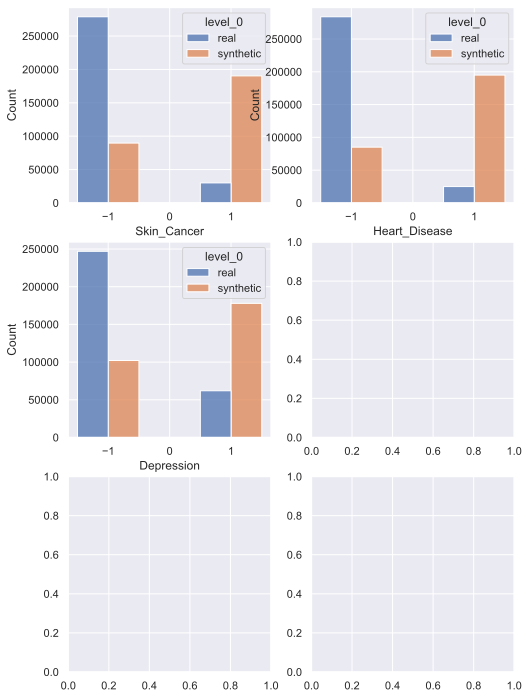

In [85]:

#viewdata = pd.concat([synthetic_data], axis=0, keys=['synthetic']).reset_index(level=[0])
viewdata = pd.concat([dsubset, synthetic_data], axis=0, keys=['real','synthetic']).reset_index(level=[0])

sb.set(style="darkgrid")
fig, axs = plt.subplots(3, 2, figsize=(8 , 12))
sb.histplot(data = viewdata, x="Skin_Cancer", bins = 4, ax=axs[0][0], discrete=True, hue='level_0', multiple="dodge", label="oneway")
sb.histplot(data = viewdata, x="Heart_Disease", bins = 4, ax=axs[0][1], discrete=True, hue='level_0', multiple="dodge", label="oneway")
#sb.histplot(data = viewdata, x="Depression", bins = 4, ax=axs[1][0], discrete=True, hue='level_0', multiple="dodge", label="oneway")
#sb.histplot(data = viewdata, x="Diabetes", bins = 4, ax=axs[1][1], discrete=True, hue='level_0', multiple="dodge", label="oneway")
#sb.histplot(data = viewdata, x="Diab-Heart", bins = 4, ax=axs[2][0], discrete=True, hue='level_0', multiple="dodge", label="diab-heart")
#dsubset.describe()
#viewdata.describe()

In [65]:
viewdata




,level_0,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Smoking_History
0,real,-1,-1,-1,-1,-1,-1,1,1
1,real,-1,1,-1,-1,-1,1,-1,-1
2,real,1,-1,-1,-1,-1,1,-1,-1
3,real,1,1,-1,-1,-1,1,-1,-1
4,real,-1,-1,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...
279996,synthetic,1,-1,-1,1,1,-1,-1,1
279997,synthetic,-1,-1,1,1,1,1,1,1
279998,synthetic,1,1,1,-1,-1,1,-1,1
279999,synthetic,1,-1,1,1,1,1,1,-1


In [86]:
print("Test")

Test


0.0006629469595013282
0.0008112559517356774
0.00023795402128691382
0.0005300770062886071
0.0006573228147615796
0.0008197032862090251
0.000548245109968971
0.0008925018618887412
0.0010168981578713495
0.0005959704511734514
0.0006499516887814574
0.0004988197960464986
0.0009686301087156161
0.000482701213656452
0.0007740480454670529
0.0006131637487953631
0.000952101144401226
0.0007458660479257107
0.0010172752312288614
0.0005961446508773701
0.0008509946855327843
0.00040859420449034883
0.0006616976621219546
0.001260503444267789
0.0012315510907299281
0.0009438665313309041
0.0007998872219861956
0.0006138877298107888
0.001009528907992151
0.0004250632546347716
0.000757998529887487
0.001072050273844011
0.0009589545935296154
0.0006734872176947101
0.0004516279279456329
0.0008212488003540143
0.000926562907495299
0.0011364625161106399
0.0007799124229837735
0.0009015368457545323
0.00033300073432737345
0.0006280893451749952
0.00048325415391632746
0.0006267967705827016
0.00038403519602712906
0.00041960561

TypeError: unhashable type: 'numpy.ndarray'

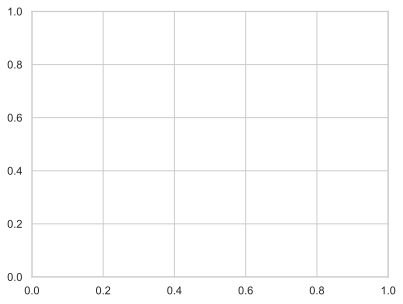

In [132]:

# Doing some tests with random covariance matrices and smallest EV.
evs = []

for i in range(1,100):
    ds = np.random.randint(2, size=(100,110))
    a = np.cov(ds)
    w, v = np.linalg.eig(a)
    evs.append(w)
    print(np.min(w))

print(evs)
print(np.mean(evs))
sb.stripplot(x=evs)



